# IMDE, Homework-2, Placement Optimization in Circuit Design

:::{warning}
It is possible to run the code on the page without downloading anything! Just press the *Launch Kernel* button and you'll be set.
:::

## Problem Description

Placement optimization is an important phase in designing circuits. Two main aspects to optimize in this problem are maximizing space utilization and wirelength minimization. 

Obviously, this problem is far outside the domain of this homework due to its sheer complexity. Typically, auto-placement algorithms are used to solve this problem, such as PCB design or CAD software.

Due to the problem's complexity, such programs utilize linear optimization only partially, to eliminate solutions which are definitely non-optimal. The placement problem otherwise is solved via many trial-and-error iterations, as well as greedy algorithms & simulated annealing methods. This problem is largely connected to graph theory, in which increasing the number nodes hastily leads to a further increase in complexity in order to unambiguously determine exact, optimal values.

Taking all this into account, a much simplified version of this problem will be considered. Effectively reducing the problem to component placement.

## Data Sources

It would have been great to consider data from a real chip to optimize, but solving such a problem for real-world values using a reduced linear programming algorithm would not yield any meaningful results since we have to use too many variables to get anything proper. 

Therefore, I introduce random values that I have hand-picked in order to not make the optimization problem too trivial.

## Mathematical Model

I will try to introduce as comprehensive of a list of parameters and restrictions as possible, while keeping everything relatively simple. Let's reduce the problem to minimizing the distance between circuit components, without any additional optimizations (like wires, their density, buffers between components, temperature regulations, location of connection, etc.) because that would exponentiate the difficulty greatly. We'll have enough with many different constraints we'll have to consider anyway.

$$\sum_{i \in C} (x_i + y_i) \to \min$$

> This homework is largely based on [this article](https://www.sciencedirect.com/science/article/pii/S2095809925001687?via%3Dihub). 

### Variables

1. $x_i$, $y_i$ — $X$ and $Y$ coordinates of component $i$'s bottom-left corner
1. $\mu_{i,z,l}$ — 1 if component $i$ is assigned to bin $z$ and layer $l$, 0 otherwise
1. $\theta_{z,l}$ — number of components assigned to bin $z$ and layer $l$
1. $\omega_{z,l}$ — 1 if layer $l$ is active in bin $z$, 0 otherwise
1. $\alpha_{i,i'}$ — 1 if component $i$ is to the left of component $i'$, 0 otherwise
1. $\beta_{i,i'}$ — 1 if component $i$ is below component $i'$, 0 otherwise
1. $\delta_x(i,j)$, $\delta_y(i,j)$ — bonus variables for non-overlap conditions
1. $\text{same\_bin}(i,j)$ — 1 if components $i$ and $j$ are in the same bin, 0 otherwise
1. $\text{aux\_}\theta\omega_{z,l}$ — bonus variable, linearized product of $\theta_{z,l}$ and $\omega_{z,l}$
1. $\text{max\_diff}$ — maximum difference in component positions
1. $\text{spread\_penalty}$ — penalty to optimize placements within the component
1. $M$ — large constant for Big-M method, creating an artificial solution in this linear programming problem 
1. $w$, $h$ — width and height of the circuit board
1. $w_i$, $h_i$ — width and height of component $i$
1. $w_z^{\text{bin}}$, $h_z^{\text{bin}}$ — width and height of each of the bins $z$
1. $f$ — packing factor
1. $w^o$, $h^o$ — orientation parameters
1. $C$ — all components
1. $Z$ — all bins
1. $L$ — all layers

### Constraints

Let's introduce all the constraints with a brief explanation of what in the world they are.

1. Components shall stay within the boundaries of the circuit board
$$0 \leq x_i \leq w - w_i,\quad 0 \leq y_i \leq h - h_i$$

2. There shall be a limit for the total components per bin based on packing density  
$$\sum_{l \in L} \theta_{z,l} \leq \frac{|C|}{fw^o h^o}$$

3. Theta tracks components assigned to each bin-layer combination 
$$\theta_{z,l} = \sum_{i \in C} \mu_{i,z,l}$$

4. Each component shall be assigned to exactly ONE bin and ONE layer 
$$\sum_{l \in L} \sum_{z \in Z} \mu_{i,z,l} = 1$$

5. Each bin shall use exactly ONE active layer 
   $$\sum_{l \in L} \omega_{z,l} = 1$$

6. Technical constraint to link continuous $\theta$ with binary $\omega$ variables
    $$\theta_{z,l} \leq M\omega_{z,l}$$

7. Component-bin assignments shall be sufficient 
    $$\sum_{i \in C} \sum_{z \in Z} \sum_{l \in L} \mu_{i,z,l} \geq \sum_{z \in Z} \sum_{l \in L} \theta_{z,l} \omega_{z,l}$$

8. Components shall fit within their assigned bin boundaries 
    $$x_z^{\text{bin}} \leq x_i \leq x_z^{\text{bin}} + w_z^{\text{bin}} - w_i$$

9.  Components shan't overlap horizontally 
    $$x_i + w_i \leq x_{i'} + M(1 - \alpha_{i,i'})$$

10. Component shan't overlap vertically
    $$y_i + h_i \leq y_{i'} + M(1 - \beta_{i,i'})$$

11. At least one non-overlap condition shall be active 
    $$\alpha_{i,i'} + \alpha_{i',i} + \beta_{i,i'} + \beta_{i',i} \geq 1$$

12. Components shan't be both left and right of each other 
    $$\alpha_{i,i'} + \alpha_{i',i} \leq 1$$

13. Components shan't be both above and below each other
    $$\beta_{i,i'} + \beta_{i',i} \leq 1$$

---

And the list of all the constraints together expanded for all coordinates:

$$
\begin{align}
&0 \leq x_i \leq w - w_i & \forall i \in C\\
&0 \leq y_i \leq h - h_i & \forall i \in C\\
&\sum_{l \in L} \theta_{z,l} \leq \frac{|C|}{fw^o h^o} & \forall z \in Z\\
&\theta_{z,l} = \sum_{i \in C} \mu_{i,z,l} & \forall z \in Z, l \in L\\
&\sum_{l \in L} \sum_{z \in Z} \mu_{i,z,l} = 1 & \forall i \in C\\
&\sum_{l \in L} \omega_{z,l} = 1 & \forall z \in Z\\
&\theta_{z,l} \leq M\omega_{z,l} & \forall z \in Z, l \in L\\
&\sum_{i \in C} \sum_{z \in Z} \sum_{l \in L} \mu_{i,z,l} \geq \sum_{z \in Z} \sum_{l \in L} \theta_{z,l} \omega_{z,l}\\
&x_{z}^{\text{bin}} \leq x_i + M(1 - \mu_{i,z,l}) & \forall i \in C, z \in Z, l \in L\\
&x_i \leq x_{z}^{\text{bin}} + w_{z}^{\text{bin}} - w_i + M(1 - \mu_{i,z,l}) & \forall i \in C, z \in Z, l \in L\\
&y_{z}^{\text{bin}} \leq y_i + M(1 - \mu_{i,z,l}) & \forall i \in C, z \in Z, l \in L\\
&y_i \leq y_{z}^{\text{bin}} + h_{z}^{\text{bin}} - h_i + M(1 - \mu_{i,z,l}) & \forall i \in C, z \in Z, l \in L\\
&x_i + w_i \leq x_{i'} + M(1 - \alpha_{i,i'}) & \forall i, i' \in C, i \neq i'\\
&y_i + h_i \leq y_{i'} + M(1 - \beta_{i,i'}) & \forall i, i' \in C, i \neq i'\\
&\alpha_{i,i'} + \alpha_{i',i} + \beta_{i,i'} + \beta_{i',i} \geq 1 & \forall i, i' \in C, i \neq i'\\
&\alpha_{i,i'} + \alpha_{i',i} \leq 1 & \forall i, i' \in C, i \neq i'\\
&\beta_{i,i'} + \beta_{i',i} \leq 1 & \forall i, i' \in C, i \neq i'\\
\end{align}
$$

## Solution

Since solving this problem would be an absolute nightmare in Excel, I use Python instead.

In [ ]:
!pip install pulp

In [ ]:
import numpy as np
import pulp
from typing import List, Tuple

class Driver:
    def __init__(self, components: List[Tuple[float, float]], 
                 bin_width: float, bin_height: float,
                 Z: List[Tuple[float, float, float, float]], 
                 L: List, f: float, w_o: float, h_o: float):
        
        self.C = components
        self.w = bin_width
        self.h = bin_height
        self.Z = Z
        self.L = L
        self.f = f
        self.w_o = w_o
        self.h_o = h_o
        
        self.n_components = len(components)
        self.n_bins = len(Z)
        self.n_layers = len(L)
        
        self.problem = pulp.LpProblem("CircuitOptimization", pulp.LpMinimize)
        
    def build_model(self):
        x = pulp.LpVariable.dicts("x", range(self.n_components), lowBound=0)
        y = pulp.LpVariable.dicts("y", range(self.n_components), lowBound=0)
        
        mu = pulp.LpVariable.dicts("mu", 
                                  [(i, z, l) for i in range(self.n_components) 
                                   for z in range(self.n_bins) for l in range(self.n_layers)],
                                  cat=pulp.LpBinary)
        
        theta = pulp.LpVariable.dicts("theta", 
                                     [(z, l) for z in range(self.n_bins) for l in range(self.n_layers)],
                                     lowBound=0)
        
        omega = pulp.LpVariable.dicts("omega", 
                                     [(z, l) for z in range(self.n_bins) for l in range(self.n_layers)],
                                     cat=pulp.LpBinary)
        
        alpha = pulp.LpVariable.dicts("alpha", 
                                     [(i, ip) for i in range(self.n_components) 
                                      for ip in range(self.n_components) if i != ip],
                                     cat=pulp.LpBinary)
        
        beta = pulp.LpVariable.dicts("beta", 
                                    [(i, ip) for i in range(self.n_components) 
                                     for ip in range(self.n_components) if i != ip],
                                    cat=pulp.LpBinary)
        
        M = 1000

        self.problem += pulp.lpSum([x[i] + y[i] for i in range(self.n_components)])
        
        ###############################################

        for i in range(self.n_components):
            w_i, h_i = self.C[i]
            self.problem += x[i] <= self.w - w_i
            self.problem += y[i] <= self.h - h_i
        
        ###############################################

        for z in range(self.n_bins):
            self.problem += pulp.lpSum([theta[z, l] for l in range(self.n_layers)]) <= self.n_components
        
        ###############################################

        for z in range(self.n_bins):
            for l in range(self.n_layers):
                self.problem += theta[z, l] == pulp.lpSum([mu[i, z, l] for i in range(self.n_components)])
        
        ###############################################

        for i in range(self.n_components):
            self.problem += pulp.lpSum([mu[i, z, l] for z in range(self.n_bins) 
                                      for l in range(self.n_layers)]) == 1
        
        ###############################################

        for z in range(self.n_bins):
            self.problem += pulp.lpSum([omega[z, l] for l in range(self.n_layers)]) == 1
        
        ###############################################

        for z in range(self.n_bins):
            for l in range(self.n_layers):
                self.problem += theta[z, l] <= M * omega[z, l]
        
        ###############################################

        total_mu = pulp.lpSum([mu[i, z, l] for i in range(self.n_components)
                              for z in range(self.n_bins) for l in range(self.n_layers)])
        
        aux_theta_omega = pulp.LpVariable.dicts("aux_theta_omega", 
                                               [(z, l) for z in range(self.n_bins) for l in range(self.n_layers)],
                                               lowBound=0)
        
        for z in range(self.n_bins):
            for l in range(self.n_layers):
                self.problem += aux_theta_omega[z, l] <= theta[z, l]
                self.problem += aux_theta_omega[z, l] <= M * omega[z, l]
                self.problem += aux_theta_omega[z, l] >= theta[z, l] - M * (1 - omega[z, l])
        
        self.problem += total_mu >= pulp.lpSum([aux_theta_omega[z, l] 
                                              for z in range(self.n_bins) for l in range(self.n_layers)])
        
        ##############################################

        for i in range(self.n_components):
            for z in range(self.n_bins):
                for l in range(self.n_layers):
                    x_bin, y_bin, w_bin, h_bin = self.Z[z]
                    w_i, h_i = self.C[i]
                    
                    self.problem += x_bin <= x[i] + M * (1 - mu[i, z, l])
                    self.problem += x[i] <= x_bin + w_bin - w_i + M * (1 - mu[i, z, l])
                    self.problem += y_bin <= y[i] + M * (1 - mu[i, z, l])
                    self.problem += y[i] <= y_bin + h_bin - h_i + M * (1 - mu[i, z, l])
        
        ##############################################

        same_bin = pulp.LpVariable.dicts("same_bin", 
                                        [(i, j) for i in range(self.n_components) 
                                         for j in range(i+1, self.n_components)],
                                        cat=pulp.LpBinary)
        
        for i in range(self.n_components):
            for j in range(i+1, self.n_components):
                for z in range(self.n_bins):
                    for l in range(self.n_layers):
                        self.problem += same_bin[i,j] >= mu[i,z,l] + mu[j,z,l] - 1
                
                w_i, h_i = self.C[i]
                w_j, h_j = self.C[j]
                
                self.problem += x[i] + w_i <= x[j] + M * (1 - alpha[i,j] + 1 - same_bin[i,j])
                self.problem += x[j] + w_j <= x[i] + M * (1 - alpha[j,i] + 1 - same_bin[i,j])
                self.problem += y[i] + h_i <= y[j] + M * (1 - beta[i,j] + 1 - same_bin[i,j])
                self.problem += y[j] + h_j <= y[i] + M * (1 - beta[j,i] + 1 - same_bin[i,j])
                
                self.problem += alpha[i,j] + alpha[j,i] + beta[i,j] + beta[j,i] >= same_bin[i,j]
        
        return x, y, mu, theta, omega
    
    def solve(self):
        x, y, mu, theta, omega = self.build_model()
        self.problem.solve(pulp.PULP_CBC_CMD(msg=1, timeLimit=60))
        
        if self.problem.status == pulp.LpStatusOptimal:
            results = {
                'status': 'Optimal',
                'objective': pulp.value(self.problem.objective),
                'placements': [],
                'assignments': [],
                'bins_used': set()
            }
            
            for i in range(self.n_components):
                x_val = pulp.value(x[i])
                y_val = pulp.value(y[i])
                w_i, h_i = self.C[i]
                results['placements'].append((i, x_val, y_val, w_i, h_i))
                
                for z in range(self.n_bins):
                    for l in range(self.n_layers):
                        if pulp.value(mu[i, z, l]) > 0.5:
                            results['assignments'].append((i, z, l))
                            results['bins_used'].add(z)
            
            return results
        
    def display_optimal_variables(self, n_components, n_bins, n_layers):        
        print("ALL OPTIMAL VARIABLE VALUES")
        
        for var in self.problem.variables():
            print(f"{var.name} = {var.varValue:.4f}")
        
        print(f"Total variables: {len(self.problem.variables())}")
        print(f"Objective value: {pulp.value(self.problem.objective):.4f}")


if __name__ == "__main__":
    components = [(2, 2), (2, 3), (3, 2), (2, 2), (1, 4), (3, 1)]
    bin_width = 8
    bin_height = 6
    
    bins = [(0, 0, 4, 6), (4, 0, 4, 6)] 
    
    # This is intentionally made trivial
    layers = [0] 

    f = 1.0  
    w_o = 1.0
    h_o = 1.0
    
    print(f"Components: {components}")
    total_component_area = sum(w*h for w,h in components)
    total_bin_area = sum(w_bin * h_bin for x_bin, y_bin, w_bin, h_bin in bins)
    print(f"Total component area: {total_component_area}")
    print(f"Total bin area: {total_bin_area}")
    print(f"Area utilization: {total_component_area/total_bin_area:.1%}")
    print(f"Bins: {len(bins)}")
    
    solver = Driver(components, bin_width, bin_height, bins, layers, f, w_o, h_o)
    results = solver.solve()
    
    print("\nSolution Status:", results['status'])
    
    if results['status'] == 'Optimal':
        print("Objective Value:", results['objective'])
        print("\nComponent Placements:")
        for placement in results['placements']:
            i, x, y, w, h = placement
            print(f"Component {i}: pos=({x:.1f}, {y:.1f}), size={w}x{h}")
        
        print("\nComponent Assignments:")
        bin_usage = {}
        for assignment in results['assignments']:
            i, z, l = assignment
            print(f"Component {i} -> Bin {z}, Layer {l}")
            if z not in bin_usage:
                bin_usage[z] = 0
            bin_usage[z] += 1
        
        print(f"\nBin usage: {bin_usage}")
        print(f"Bins used: {len(results['bins_used'])}")
        
        solver.display_optimal_variables(solver.n_components, solver.n_bins, solver.n_layers)

Components: [(2, 2), (2, 3), (3, 2), (2, 2), (1, 4), (3, 1)]
Total component area: 27
Total bin area: 48
Area utilization: 56.2%
Bins: 2

Solution Status: Optimal
Objective Value: 15.0

Component Placements:
Component 0: pos=(2.0, 0.0), size=2x2
Component 1: pos=(4.0, 0.0), size=2x3
Component 2: pos=(1.0, 3.0), size=3x2
Component 3: pos=(0.0, 0.0), size=2x2
Component 4: pos=(0.0, 2.0), size=1x4
Component 5: pos=(1.0, 2.0), size=3x1

Component Assignments:
Component 0 -> Bin 0, Layer 0
Component 1 -> Bin 1, Layer 0
Component 2 -> Bin 0, Layer 0
Component 3 -> Bin 0, Layer 0
Component 4 -> Bin 0, Layer 0
Component 5 -> Bin 0, Layer 0

Bin usage: {0: 5, 1: 1}
Bins used: 2
ALL OPTIMAL VARIABLE VALUES
alpha_(0,_1) = 0.0000
alpha_(0,_2) = 0.0000
alpha_(0,_3) = 0.0000
alpha_(0,_4) = 0.0000
alpha_(0,_5) = 0.0000
alpha_(1,_0) = 0.0000
alpha_(1,_2) = 0.0000
alpha_(1,_3) = 0.0000
alpha_(1,_4) = 0.0000
alpha_(1,_5) = 0.0000
alpha_(2,_0) = 0.0000
alpha_(2,_1) = 0.0000
alpha_(2,_3) = 0.0000
alpha_(2

## Conclusion

The problem considered in this homework was definitely solved. However, the problem at question is, unfortunately, quite a rudimentary version of what can actually be used when solving real-life problems.

Using plain linear programming is insufficient to solve these kinda problems in reasonable time, and increasing the number of components or bins leads to an exponential rise in complexity and time required to solve it.

Nevertheless, it was reasonably fun to try and consider all the endless constraints required to solve even a crude version of a circuit optimization problem. It successfully positioned these components on a grid (which is a reduced version of a circuit board, after all), packing all the components very close to each other and not leaving any gaps. I would consider this a massive success.

Visualization for the [example considered in the work.](https://www.desmos.com/calculator/w8e9gtjw64)

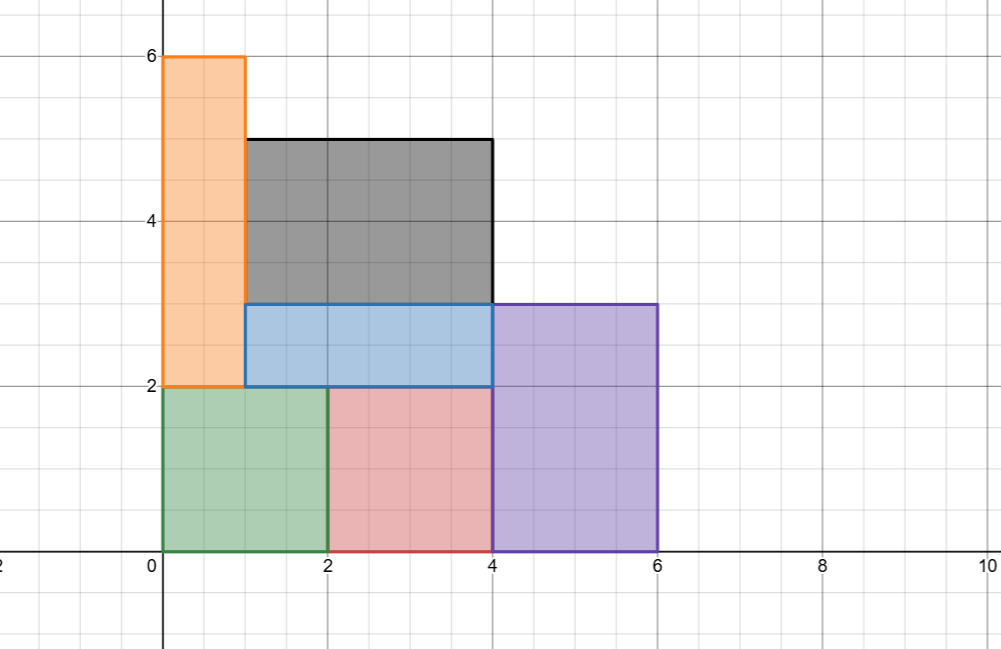